In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import itertools

In [2]:
def s_polynomial(f, g):
    return sp.expand(sp.lcm(sp.LM(f), sp.LM(g))*(1/sp.LT(f)*f - 1/sp.LT(g)*g))

def buchberger(F, reduce=True):
    G, pairs = list(F), set([])

    for f1f2 in itertools.combinations(F,2):
        pairs.add((f1f2))

    while pairs:
        f1, f2 = pairs.pop()

        s = s_polynomial(f1, f2)
        _, h = sp.reduced(s, G)

        if h != 0:
            for g in G:
                pairs.add((g, h))

            G.append(h)

    if reduce:
        for i, g in enumerate(G):
            Gi = G[i+1:] + G[:i]
            Gi = [g for g in Gi if not g.is_zero]
            _, G[i] = sp.reduced(g, Gi)
        G = [g for g in G if not g.is_zero]
        G = list(map(sp.monic, G))

    return G

In [3]:
x, y = sp.symbols('x y')
F = [x**2 + 2*x*y**2, x*y + 2*y**3 - 1]
G = buchberger(F, reduce=False)
print(G)

[x**2 + 2*x*y**2, x*y + 2*y**3 - 1, x, -4*y**4 + 2*y, 2*y**3 - 1]


In [4]:
B = buchberger(F, reduce=True)
print(B)

[x, y**3 - 1/2]


Find the key, $k$, used in encryption as cipher =  $(x+k)^3 + x*k$, where x is the plain text.

In [5]:
def polynomial_encrypt(plaintext, key):
    return (plaintext + key)**3 + plaintext * key

plaintext = 5
key = 7
ciphertext = polynomial_encrypt(plaintext, key)

print(f"Plaintext: {plaintext}, Ciphertext: {ciphertext}")

def groebner_basis_attack(ciphertext, plaintext):
    k = sp.symbols('k')
    x = sp.symbols('x')
    y = sp.symbols('y')

    f = (x + k)**3 + x * k - y

    f_sub = f.subs({x: plaintext, y: ciphertext})

    groebner_basis = sp.groebner([f_sub], k, order='lex')
    return groebner_basis

attack_basis = groebner_basis_attack(ciphertext, plaintext)
print("\nGroebner Basis:")
for poly in attack_basis:
    print(poly)

key_solutions = sp.solve(attack_basis, sp.symbols('k'))
print("\nRecovered Key:", key_solutions)

Plaintext: 5, Ciphertext: 1763

Groebner Basis:
k**3 + 15*k**2 + 80*k - 1638

Recovered Key: [(7,), (-11 - sqrt(113)*I,), (-11 + sqrt(113)*I,)]



Let's try to find the key, k, used in polynomial equation system encryption as cipher with <br>  $y_1 = (x+k)^3 + x*k$, and

$y_2 = x^3+x*k^2$ where x is the plain text.

In [6]:
def polynomial_encrypt_system(plaintext, key):
    y1 = (plaintext + key)**3 + plaintext * key
    y2 = (plaintext)**3 + plaintext * key * key
    return y1, y2

plaintext = 5
key = 7
y1, y2 = polynomial_encrypt_system(plaintext, key)

print(f"Plaintext: {plaintext}, Ciphertext y1: {y1}, Ciphertext y2: {y2}")

def groebner_basis_attack_system(ciphertext1, ciphertext2, plaintext):
    k = sp.symbols('k')
    x = sp.symbols('x')
    y1, y2 = sp.symbols('y1 y2')

    eq1 = (x + k)**3 + x * k - y1
    eq2 = (x)**3 + x * k * k - y2

    eq1_sub = eq1.subs({x: plaintext, y1: ciphertext1})
    eq2_sub = eq2.subs({x: plaintext, y2: ciphertext2})

    groebner_basis = sp.groebner([eq1_sub, eq2_sub], k, order='lex')
    return groebner_basis

groebner_basis_system = groebner_basis_attack_system(y1, y2, plaintext)

print("\nGroebner Basis for the system of equations:")
for poly in groebner_basis_system:
    print(poly)

key_solutions = sp.solve(groebner_basis_system, sp.symbols('k'))
print("\nRecovered Key:", key_solutions)

Plaintext: 5, Ciphertext y1: 1763, Ciphertext y2: 370

Groebner Basis for the system of equations:
k - 7

Recovered Key: {k: 7}


### Example
Let's try to find the intersection of three curves, the sphere of radius 2 <br> i.e. $x^2 + y^2 + z^2 =4$, the cylinder $x^2 + 2y^2 = 5$, and the bilinear function $xz = 1$.

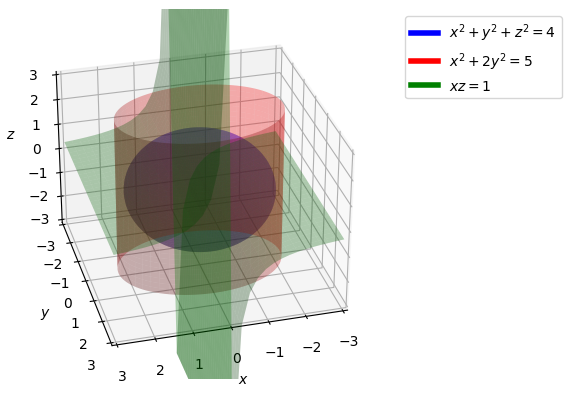

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Draw sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x1 = 2 * np.outer(np.cos(u), np.sin(v))
y1 = 2 * np.outer(np.sin(u), np.sin(v))
z1 = 2 * np.outer(np.ones(np.size(u)), np.cos(v))
surf1 = ax.plot_surface(x1, y1, z1, color='b', alpha=0.3)

# Draw cylinder
z2 = np.linspace(-3, 3, 30)
U, z2 = np.meshgrid(u, z2)
x2 = np.sqrt(5) * np.cos(U)
y2 = np.sqrt(5 / 2) * np.sin(U)
surf2 = ax.plot_surface(x2, y2, z2, color='r', alpha=0.3)

# Draw bilinear surface
x3 = np.linspace(-3, 3, 30)
y3 = np.linspace(-3, 3, 30)
x3, y3 = np.meshgrid(x3, y3)
z3 = 1 / (x3 + 1e-10)  # Prevent division by zero
surf3 = ax.plot_surface(x3, y3, z3, color='g', alpha=0.3)


legend_elements = [
    Line2D([0], [0], color='b', lw=4, label=r'$x^2 + y^2 + z^2 =4$'),
    Line2D([0], [0], color='r', lw=4, label=r'$x^2 + 2y^2 = 5$'),
    Line2D([0], [0], color='g', lw=4, label=r'$xz = 1$')
]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')

ax.view_init(30, 75)

plt.show()

In [8]:
x, y, z = sp.symbols('x y z')
eqs = [x**2 + y**2 + z**2 - 4 , x**2 + 2*y**2 - 5, x*z - 1]
print(eqs)

[x**2 + y**2 + z**2 - 4, x**2 + 2*y**2 - 5, x*z - 1]


In [9]:
result = sp.groebner(eqs, x, y, z, order='lex')
list(result)

[x + 2*z**3 - 3*z, y**2 - z**2 - 1, 2*z**4 - 3*z**2 + 1]

In [10]:
z_ans = sp.solve(list(result)[-1], z)
print(z_ans)

[-1, 1, -sqrt(2)/2, sqrt(2)/2]


In [11]:
y_ans = []
for zs in z_ans:
    y_ans.append(sp.solve(list(result)[1].subs(z, zs)))
print(y_ans)
y_ans_1 = np.array([float(item[0].evalf()) for item in y_ans])
y_ans_2 = np.array([float(item[1].evalf()) for item in y_ans])

[[-sqrt(2), sqrt(2)], [-sqrt(2), sqrt(2)], [-sqrt(6)/2, sqrt(6)/2], [-sqrt(6)/2, sqrt(6)/2]]


In [12]:
x_ans = []
for zs in z_ans:
    x_ans.append(sp.solve(list(result)[0].subs(z, zs)))
x_ans = [item for sublist in x_ans for item in sublist]
print(x_ans)

[-1, 1, -sqrt(2), sqrt(2)]


In [13]:
sp.solve(eqs)

[{x: -1, y: -sqrt(2), z: -1},
 {x: -1, y: sqrt(2), z: -1},
 {x: 1, y: -sqrt(2), z: 1},
 {x: 1, y: sqrt(2), z: 1},
 {x: -sqrt(2), y: -sqrt(6)/2, z: -sqrt(2)/2},
 {x: -sqrt(2), y: sqrt(6)/2, z: -sqrt(2)/2},
 {x: sqrt(2), y: -sqrt(6)/2, z: sqrt(2)/2},
 {x: sqrt(2), y: sqrt(6)/2, z: sqrt(2)/2}]

Let's try to find the intersection of six polynomial curves (or surfaces):

1. $(x + k)^5 + x^4 k^2 + k^3 + xk = y_1$

2. $   x^5 + x^3 k^2 + x^2 k + k^4 = y_2$

3. $x^4 + k^2 x k + x k^3 = y_3$

4. $k^5 + x^3 k + x^2 k^3 + x k^2 = y_4$

5. $(x + k)^4 + x^3 k + k^3 + x^2 k^2 = y_5$

6. $x^5 + k^4 + x k^3 + k^2 x^2 = y_6$

We will solve for $k$, the unknown, by finding the intersection of these six curves.


In [14]:
def polynomial_encrypt_system(plaintext, key):
    y1 = (plaintext + key)**5 + plaintext**4 * key**2 + key**3 + plaintext * key
    y2 = (plaintext)**5 + plaintext**3 * key**2 + plaintext**2 * key + key**4
    y3 = plaintext**4 + key**2 * plaintext * key + plaintext * key**3
    y4 = key**5 + plaintext**3 * key + plaintext**2 * key**3 + plaintext * key**2
    y5 = (plaintext + key)**4 + plaintext**3 * key + key**3 + plaintext**2 * key**2
    y6 = plaintext**5 + key**4 + plaintext * key**3 + key**2 * plaintext**2
    return y1, y2, y3, y4, y5, y6

plaintext = 5
key = 7
y1, y2, y3, y4, y5, y6 = polynomial_encrypt_system(plaintext, key)

print(f"Plaintext: {plaintext}")
print(f"Ciphertexts: y1: {y1}, y2: {y2}, y3: {y3}, y4: {y4}, y5: {y5}, y6: {y6}")

def groebner_basis_attack_system(ciphertexts, plaintext):
    k = sp.symbols('k')
    x = sp.symbols('x')
    y1, y2, y3, y4, y5, y6 = sp.symbols('y1 y2 y3 y4 y5 y6')

    eq1 = (x + k)**5 + x**4 * k**2 + k**3 + x * k - y1
    eq2 = x**5 + x**3 * k**2 + x**2 * k + k**4 - y2
    eq3 = x**4 + k**2 * x * k + x * k**3 - y3
    eq4 = k**5 + x**3 * k + x**2 * k**3 + x * k**2 - y4
    eq5 = (x + k)**4 + x**3 * k + k**3 + x**2 * k**2 - y5
    eq6 = x**5 + k**4 + x * k**3 + k**2 * x**2 - y6

    eq1_sub = eq1.subs({x: plaintext, y1: ciphertexts[0]})
    eq2_sub = eq2.subs({x: plaintext, y2: ciphertexts[1]})
    eq3_sub = eq3.subs({x: plaintext, y3: ciphertexts[2]})
    eq4_sub = eq4.subs({x: plaintext, y4: ciphertexts[3]})
    eq5_sub = eq5.subs({x: plaintext, y5: ciphertexts[4]})
    eq6_sub = eq6.subs({x: plaintext, y6: ciphertexts[5]})

    groebner_basis = sp.groebner([eq1_sub, eq2_sub, eq3_sub, eq4_sub, eq5_sub, eq6_sub], k, order='lex')
    return groebner_basis

groebner_basis_system = groebner_basis_attack_system([y1, y2, y3, y4, y5, y6], plaintext)

print("\nGroebner Basis for the system of equations:")
for poly in groebner_basis_system:
    print(poly)

key_solutions = sp.solve(groebner_basis_system, sp.symbols('k'))
print("\nRecovered Key:", key_solutions)


Plaintext: 5
Ciphertexts: y1: 279835, y2: 11826, y3: 4055, y4: 26502, y5: 23179, y6: 8466

Groebner Basis for the system of equations:
k - 7

Recovered Key: {k: 7}


In [15]:
x, y = sp.symbols('x y')
eqs = [x**2 + y**2 + 7*x*y -2*y , x + y**3 - 3]
print(eqs)

[x**2 + 7*x*y + y**2 - 2*y, x + y**3 - 3]


In [16]:
result = sp.groebner(eqs, x, y, order='lex')
list(result)

[x + y**3 - 3, y**6 - 7*y**4 - 6*y**3 + y**2 + 19*y + 9]

In [17]:
G = buchberger(eqs, reduce=False)
print(G)

[x**2 + 7*x*y + y**2 - 2*y, x + y**3 - 3, y**6 - 7*y**4 - 6*y**3 + y**2 + 19*y + 9]


In [18]:
G = buchberger(eqs, reduce=True)
print(G)

[x + y**3 - 3, y**6 - 7*y**4 - 6*y**3 + y**2 + 19*y + 9]


In [19]:
import sympy as sp
import numpy as np
from sympy import symbols, Poly

In [20]:
def phi_func(vector):
    d = sp.symbols('delta')
    result = 0
    for i, poly in enumerate(vector):
        result += poly * (d ** i)
    return result

In [21]:
def phi_inv(single_poly):
    d = sp.symbols('delta')
    result = []
    
    terms = single_poly.as_ordered_terms()
    #print(terms)
    constant_terms = 0
    for term in terms:
     #   print(f"Processing term: {term}")
        if term.has(d):
            while term.has(d):  
                coefficient = term.as_coefficients_dict().get(d, 1)  
                term = term / d  
                # print(f"Polynomial part without delta: {term}")
            
            result.append(term)
        else:
            constant_terms += term
    result.append(constant_terms)
    
    return result

In [22]:
def create_invertible_matrix(n):
    matrix = np.random.randint(0, 2, (n, n))
    while np.linalg.det(matrix) == 0:
        matrix = np.random.randint(0, 2, (n, n))
    return sp.Matrix(matrix)

In [23]:
def reduce_mod_delta(poly, modulus, variable):
    """Reduce a polynomial modulo a given modulus."""
    poly = sp.Poly(poly, variable)
    modulus = sp.Poly(modulus, variable)
    _, remainder = divmod(poly, modulus)
    
    return remainder.as_expr()

def Central_F(poly):
    d = sp.symbols('delta')
    poly = poly**3 + poly + poly**2 + 1
    modulus = d**3 + d**2 + 1
    
    reduced_poly = reduce_mod_delta(poly.expand(), modulus, d)
    
    return reduced_poly

# Example Usage
# delta, x1, x2 = sp.symbols('delta x1 x2')
# poly = delta * x2 + x1
# reduced = Central_F(poly)
# print("Reduced Polynomial:", reduced)

In [24]:
def encrypt_message(n, m):
    x = sp.Matrix([sp.symbols(f'x{i}') for i in range(1, n+1)])  # x1, x2, ..., xn
    
    A = create_invertible_matrix(n)
    
    C = create_invertible_matrix(m)
    
    b = sp.Matrix(np.random.choice([0, 1], size=n))  
    d = sp.Matrix(np.random.choice([0, 1], size=m))      
    
    T = A * x + b 

    Y = phi_func(T)
    
    Z = Central_F(Y)

    z = sp.Matrix(phi_inv(Z))
    
    S = C * z + d
    p = sp.Matrix(S)  # Final ciphertext
    
    # Public key as the polynomial set S(F(T(x)))
    public_key = p
    return public_key


In [25]:

# Function to display the encryption process
def show_encryption(n, m):
    public_key = encrypt_message(n, m)
    
    print("\nPublic Key (S(F(T(x)))):")
    print(public_key)
    return public_key

n = 3  # Length of message vector x
m = 3  # Length of cipher text vector z

key = show_encryption(n, m)



Public Key (S(F(T(x)))):
Matrix([[-x1**3 - 3*x1**2 + 3*x1*x2**2 - 6*x1*x2*x3 - 4*x1*x2 - 2*x1*x3 - 4*x1 + x2**3 + 4*x2**2 - 6*x2*x3 - 3*x2 + x3**3 + 3*x3**2 + x3 + 1], [-2*x1**3 + 3*x1**2*x2 + 6*x1**2*x3 + x1**2 - 12*x1*x2*x3 - 6*x1*x2 - 9*x1*x3**2 - 10*x1*x3 - 5*x1 + x2**3 + 3*x2**2*x3 + 4*x2**2 + 6*x2*x3**2 + 2*x2*x3 + 5*x3**3 + 8*x3**2 + 4*x3 + 2], [-x1**3 + 3*x1**2*x3 - 6*x1*x2*x3 - 6*x1*x2 - 3*x1*x3**2 - 2*x1*x3 - 2*x1 + x2**3 + x2**2 + 3*x2*x3**2 - 2*x2 + 2*x3**3 + 4*x3**2 + 3*x3 + 2]])


In [34]:
def encrypt(x1_val,x2_val,x3_val,key):
    x1, x2, x3 = symbols('x1 x2 x3')
    evaluated_matrix = key.subs({x1: x1_val, x2: x2_val, x3: x3_val})
    return evaluated_matrix

cipher = encrypt(1,2,1,key)
print(encrypt(1,2,1,key))

Matrix([[-6], [22], [-4]])


In [35]:
#groebener basis attack

In [36]:
p1 = key[0]
p2 = key[1]
p3 = key[2]

In [37]:
c1 = cipher[0]
c2 = cipher[1]
c3 = cipher[2]

In [38]:
eq1 = p1 - c1
eq2 = p2 - c2
eq3 = p3 - c3
x1, x2, x3 = symbols('x1 x2 x3')

In [39]:
%%time
grobner_basis = sp.groebner([eq1, eq2, eq3], [x1, x2, x3], domain="QQ")

CPU times: total: 57.9 s
Wall time: 1min 32s


In [40]:
%%time
solutions = sp.solve(grobner_basis, (x1, x2, x3))

CPU times: total: 31.2 ms
Wall time: 181 ms


In [41]:
print("Gröbner Basis:")
for g in grobner_basis:
    print(g)

print("\nSolutions for x1, x2, x3:")
print(solutions)

Gröbner Basis:
x1 + 17365482453803305206084202936666609317206001052176946166888673404282414025980511139580009598808891972805449880970946257742018285379588*x3**26/12360254470677776329416935406229254625721298357784973373661680346467214385326917226328440827932954517880531818933893907280943534596673517 + 430669177621060379257349474814248473318588762640119131579704823540055904553977033043630634835829195549501698265813586710715541331381227*x3**25/12360254470677776329416935406229254625721298357784973373661680346467214385326917226328440827932954517880531818933893907280943534596673517 + 5103071847297400355236592526782295793927101817490376895853961835036562314146818449405363121905058874371569271239942273116601192690131695*x3**24/12360254470677776329416935406229254625721298357784973373661680346467214385326917226328440827932954517880531818933893907280943534596673517 + 11666513519750579171538544841616660087638898331712171111948565697230819383104517310726788048417659755126049844938557810156388477142